# <center> <u> Question 2</u> Neo4j </center>

## <center> 2a) <I><u> Graph Database </u> </I> </center>

I have imported an image of my Property Graph Model and displayed it below. To ensure that it's accessible by anyone, I have put the image in the same folder and used a relative filepath to access it. I created the Property Graph Model using Arrows.app and adapting it from my ER Model.

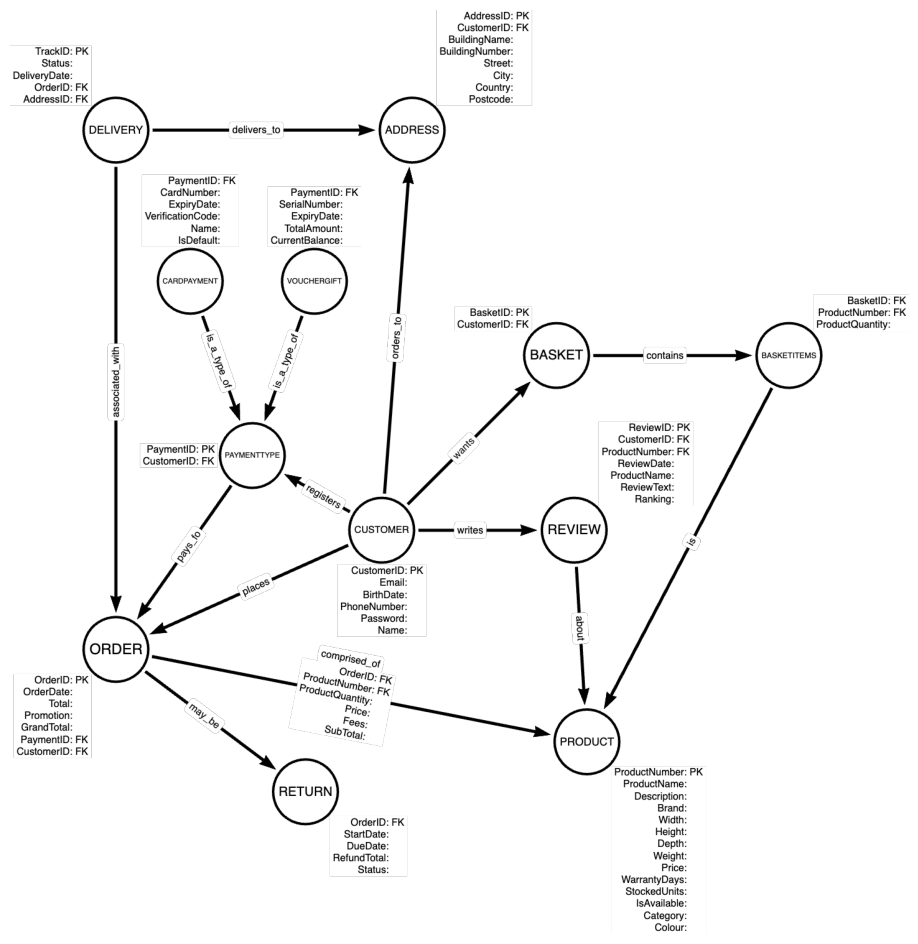

In [6]:
import matplotlib.pyplot as plt

# displaying the image
img = plt.imread("data/PropertyGraphModel.png")
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()


For setting up the Neo4j database and executing queries, I used the code we learned in Seminar 9 as a guideline. First, I imported the libraries required for this question and then to set up the connection, I created a cluster on AuraDB and noted the URI, user, and password which I then used in the Graph Database Driver. Finally, I copied the function used in the seminar which allows me to be more efficient with my code by only needing to access the function to run the query. 

In [7]:
# importing necessary libraries
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable
import logging

# creating connection
URI = "neo4j+s://5e29471e.databases.neo4j.io" 
user = "neo4j"
password = "2QiW7i2LiStEqozOK2upyqa5nzXdjSp-oW1lAMNPJRw"
AUTH = (user, password)
    
driver = GraphDatabase.driver(URI, auth=AUTH)
driver.verify_connectivity()

# Function to run a single query
def run_query(query, params=None):
    with driver.session() as session:
        return session.run(query, params)

## <center> 2b) <I><u> Populating Data </u> </I> </center>

### <i> Creating Queries to Load Data </i>

To populate the data, I used data that I had saved on Google Sheets. The data is from the previous project and is a mix of random generation and AI prompts on Mockaroo.com as well as some manual data generation and checking to ensure that foreign keys match up and data/relationships stay consistent. To ensure that the queries properly access the data, the Sheets are publically accessible by link and converted to CSV format. 

I imported the data using <i> LOAD CSV WITH HEADERS </i> command to read the data and <i> MERGE </i> to match it. For each node, I created a seperate query and checked the headers to make sure the names of the node properties were accurate and used <i> SET </i>. I also kept the datatypes as accurate as I could by using functions like <i> toFloart() </i> and <i> toInteger() </i> Then I created relationships between nodes using <i> MERGE </i> again. 

Finally, I used the function <i> run_query </i> to run all of the queries.

<b> Considerations: </b>

While I was importing the data, I initially intended to import first and then create the relationships in a different step but I realised that I would have to load the data again and it was more efficient to just create the relationships alongside importing the data. 

Another issue I came across was an error saying "CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: WITH is required between MERGE and MATCH (line 7, column 1 (offset: 306))}". To resolve this, I had to google it and got this link: https://stackoverflow.com/questions/32156721/cypher-with-is-required-between-create-and-match. Which told me that I can't use <i> MERGE </i> and <i> MATCH </i> clauses directly without seperating them with <i> WITH </i>.

In [8]:
load_customer = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=0' AS row
CREATE (:Customer {
    CustomerID: toInteger(row.CustomerID),
    Email: row.Email,
    BirthDate: row.BirthDate,
    PhoneNumber: row.PhoneNumber,
    Password: row.Password,
    Name: row.Name
});
'''

load_address = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1363769447' AS row
MERGE (a:Address {AddressID: toInteger(row.AddressID)})
WITH a, row
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:HAS_ADDRESS]->(a)
SET a.BuildingName = row.BuildingName,
    a.BuildingNumber = row.BuildingNumber,
    a.Street = row.Street,
    a.City = row.City,
    a.Country = row.Country,
    a.Postcode = row.Postcode
'''

load_billingaddress = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=29567519' AS row
MERGE (ba:BillingAddress {AddressID: toInteger(row.AddressID)})
WITH ba, row
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:HAS_BILLING_ADDRESS]->(ba)
'''

load_shippingaddress = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1644962642' AS row
MERGE (sa:ShippingAddress {AddressID: toInteger(row.AddressID)})
WITH sa, row
MATCH (a:Address {AddressID: toInteger(row.AddressID)})
MERGE (sa)-[:SHIPPED_TO]->(a)
SET sa.DeliveryInstructions = row.DeliveryInstructions
'''

load_paymenttype = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1010878887' AS row
MERGE (pt:PaymentType {PaymentID: toInteger(row.PaymentID)})
MERGE (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:HAS_PAYMENT]->(pt)
'''

load_cardpayment = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=281978725' AS row
MERGE (cp:CardPayment {PaymentID: toInteger(row.PaymentID)})
WITH cp, row
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:MADE_CARD_PAYMENT]->(cp)
WITH cp, row
MATCH (p:PaymentType {PaymentID: toInteger(row.PaymentID)})
MERGE (cp)-[:IS_A]->(p)
SET cp.CardNumber = row.CardNumber,
    cp.ExpiryDate = row.ExpiryDate,
    cp.VerificationCode = row.VerificationCode,
    cp.Name = row.Name,
    cp.IsDefault = CASE WHEN row.IsDefault = 'true' THEN true ELSE false END
'''

load_vouchergift = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1071206466' AS row
MERGE (vg:VoucherGift {PaymentID: toInteger(row.PaymentID)})
SET vg.SerialNumber = row.SerialNumber,
    vg.ExpiryDate = row.ExpiryDate,
    vg.TotalAmount = toFloat(row.TotalAmount),
    vg.CurrentBalance = toFloat(row.CurrentBalance)
WITH vg, row
MATCH (pt:PaymentType {PaymentID: toInteger(row.PaymentID)})
MERGE (pt)-[:IS_A]->(vg)
'''

load_product = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=357046785' AS row
MERGE (p:Product {ProductNumber: toInteger(row.ProductNumber)})
SET p.ProductName = row.ProductName,
    p.Brand = row.Brand,
    p.Width = toFloat(row.Width),
    p.Height = toFloat(row.Height),
    p.Depth = toFloat(row.Depth),
    p.Weight = toFloat(row.Weight),
    p.Price = toFloat(row.Price),
    p.WarrantyDays = toInteger(row.WarrantyDays),
    p.StockedUnits = toInteger(row.StockedUnits),
    p.IsAvailable = (row.IsAvailable = 'TRUE'),
    p.Description = row.Description
'''

load_productrelations = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1869516814' AS row
MATCH (p:Product {ProductNumber: toInteger(row.ProductNumber)}), (c:Category {CategoryID: toInteger(row.CategoryID)})
MERGE (pc:ProductCategory {ProductNumber: toInteger(row.ProductNumber), CategoryID: toInteger(row.CategoryID)})
MERGE (p)-[:BELONGS_TO]->(c)
MERGE (p)-[:HAS_CATEGORY]->(pc)
'''

load_productcategory = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1869516814' AS row
MATCH (p:Product {ProductNumber: toInteger(row.ProductNumber)}), (c:Category {CategoryID: toInteger(row.CategoryID)})
MERGE (pc:ProductCategory {ProductNumber: toInteger(row.ProductNumber), CategoryID: toInteger(row.CategoryID)})
MERGE (p)-[:BELONGS_TO]->(c)
MERGE (p)-[:HAS_CATEGORY]->(pc)
'''

load_category = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=424355899' AS row
MERGE (c:Category {CategoryID: toInteger(row.CategoryID), CategoryName: row.CategoryName})
'''

load_productcolour = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=501405045' AS row
MATCH (p:Product {ProductNumber: toInteger(row.ProductNumber)}), (c:Colour {ColourID: toInteger(row.ColourID)})
MERGE (pc:ProductColour {ProductNumber: toInteger(row.ProductNumber), ColourID: toInteger(row.ColourID)})
MERGE (p)-[:HAS_COLOUR]->(c)
MERGE (p)-[:HAS_COLOUR]->(pc)
'''

load_colour = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1294232835' AS row
MERGE (c:Colour {ColourID: toInteger(row.ColourID), ColourName: row.ColourName})
'''

load_basket = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=290513748' AS row
MERGE (b:Basket {BasketID: toInteger(row.BasketID), CustomerID: toInteger(row.CustomerID)})
WITH row, b
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:HAS_BASKET]->(b)
'''

load_basketitems = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1334406924' AS row
MERGE (bi:BasketItem {BasketID: toInteger(row.BasketID), ProductNumber: toInteger(row.ProductNumber)})
WITH row, bi
MERGE (b:Basket {BasketID: toInteger(row.BasketID)})
MERGE (p:Product {ProductNumber: toInteger(row.ProductNumber)})
MERGE (b)-[:CONTAINS_ITEM]->(bi)
MERGE (bi)-[:IS_OF_PRODUCT]->(p)
SET bi.ProductQuantity = toInteger(row.ProductQuantity)
'''

load_order = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1528449684' AS row
MERGE (o:Order {OrderID: toInteger(row.OrderID)})
SET o.OrderDate = row.OrderDate, 
    o.Promotion = toFloat(row.Promotion),
    o.Total = toFloat(row.Total),
    o.GrandTotal = toFloat(row.GrandTotal)
WITH o, row  
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})
MERGE (c)-[:PLACED_ORDER]->(o)
'''

load_orderproduct = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=561052019' AS row
MERGE (op:OrderProduct {OrderID: toInteger(row.OrderID), ProductNumber: toInteger(row.ProductNumber)})
WITH row, op  
MATCH (o:Order {OrderID: toInteger(row.OrderID)}), (p:Product {ProductNumber: toInteger(row.ProductNumber)})
MERGE (o)-[:CONTAINS_PRODUCT]->(p)  
MERGE (op)-[:IS_PRODUCT_IN_ORDER]->(p) 
SET op.ProductQuantity = toInteger(row.ProductQuantity),
    op.Price = toFloat(row.Price),
    op.Fees = toFloat(row.Fees),
    op.Subtotal = toFloat(row.Subtotal)
'''


load_delivery = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=807897491' AS row
MERGE (d:Delivery {TrackID: row.TrackID, OrderID: toInteger(row.OrderID)})
WITH row, d
MATCH (a:Address {AddressID: toInteger(row.AddressID)})  // Ensure to match the Address node
MERGE (d)-[:DELIVERED_TO]->(a)
SET d.Status = row.Status,
    d.DeliveryDate = row.DeliveryDate
'''

load_review = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=844412967' AS row
MERGE (r:Review {ReviewID: toInteger(row.ReviewID)})
WITH row, r
MATCH (c:Customer {CustomerID: toInteger(row.CustomerID)})  // Match Customer by CustomerID
MATCH (p:Product {ProductNumber: toInteger(row.ProductNumber)})  // Match Product by ProductNumber
MERGE (r)-[:WROTE]->(c)
MERGE (r)-[:REVIEWS]->(p)
SET r.ReviewDate = row.ReviewDate,
    r.ReviewText = row.ReviewText,
    r.Ranking = toInteger(row.Ranking),
    r.ProductName = row.ProductName
'''

load_return = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1608732692' AS row
MERGE (r:Return {OrderID: toInteger(row.OrderID)})
WITH row, r
MATCH (o:Order {OrderID: toInteger(row.OrderID)})
MERGE (r)-[:FOR_ORDER]->(o)
SET r.StartDate = row.StartDate,
    r.DueDate = row.DueDate,
    r.RefundTotal = toFloat(row.RefundTotal),
    r.Status = row.Status
'''

### <i> Running the import queries </i>

In [9]:
with driver.session(database="neo4j") as session:
    session.run(load_customer)
    session.run(load_address)
    session.run(load_billingaddress) 
    session.run(load_shippingaddress)
    session.run(load_paymenttype)
    session.run(load_cardpayment)
    session.run(load_vouchergift)
    session.run(load_product)
    session.run(load_productrelations)
    session.run(load_productcategory)
    session.run(load_category)
    session.run(load_productcolour)
    session.run(load_colour)
    session.run(load_basket)
    session.run(load_basketitems)
    session.run(load_order)
    session.run(load_orderproduct)
    session.run(load_delivery)
    session.run(load_review)
    session.run(load_return)

## <center> 2c) <I><u> Customers and Orders </u> </I> </center>

I first checked that the data was loaded correctly and that the relationships between the Order, Product, and OrderProduct nodes were consistent and matched properly. The query and output verify this. 

Next, I had to write code to compute the Grand Total for each order as this is a derived value. I do this by matching order to product and getting orderproduct so I can access all the attributes. First, I have a calculated price which is simply the unit price of each product in the order multiplied by it's product quantity. Next, to get the subtotal, I subtract the fees associated with each product order. Then to get the total, I add all the subtotals of the individual products in an order. Finally, I account for promotion which I had in the previous assignment defined to be a certain percentage off an entire order after fees so to calculate the grand total of an order, I multiple total by (1 - promotion). Then, to ensure that this calculation was done correctly, I used <i> RETURN </i> with <i> LIMIT </i> set to 5 to check the output.

Then I used a query by first matching the relevant nodes and adding the <i> COLLECT </i> function which aggregates the list of products and their quantities. I also ordered by OrderID to make the output logical. For displaying the result, in order to make it both visually pleasing and easy to read, I made use of Python functions like <i> join </i> wiht comma and printing a divider line. 

In [12]:
# query to check data is matched correctly
checker_order_product = '''
MATCH (o:Order)-[:CONTAINS_PRODUCT]->(p:Product)
MATCH (op:OrderProduct {OrderID: o.OrderID, ProductNumber: p.ProductNumber})
RETURN o.OrderID AS OrderID, 
       p.ProductNumber AS ProductNumber, 
       op.ProductQuantity AS ProductQuantity, 
       op.Fees AS Fees,
       op.Price AS Price
LIMIT 5
'''

# running query
with driver.session(database="neo4j") as session:
    result_op = session.run(checker_order_product)
    for record in result_op:
        print(record)

<Record OrderID=30 ProductNumber=1 ProductQuantity=8 Fees=3.02 Price=None>
<Record OrderID=36 ProductNumber=1 ProductQuantity=10 Fees=8.18 Price=None>
<Record OrderID=209 ProductNumber=1 ProductQuantity=8 Fees=7.22 Price=None>
<Record OrderID=7 ProductNumber=2 ProductQuantity=4 Fees=7.06 Price=None>
<Record OrderID=13 ProductNumber=2 ProductQuantity=6 Fees=9.94 Price=None>


In [13]:
# query to calculate grand totals of orders
calculate = '''
// calculating individual product prices
MATCH (o:Order)-[:CONTAINS_PRODUCT]->(p:Product)
MATCH (op:OrderProduct {OrderID: o.OrderID, ProductNumber: p.ProductNumber})
SET op.CalculatedPrice = p.Price * op.ProductQuantity

// calculating subtotals
SET op.Subtotal = op.CalculatedPrice - op.Fees

// calculating totals
WITH o, SUM(op.Subtotal) AS OrderTotal
SET o.Total = OrderTotal

// calculating grandtotal with promotion
SET o.GrandTotal = o.Total * (1 - o.Promotion)

RETURN o.OrderID AS OrderID, o.Total AS Total, o.GrandTotal AS GrandTotal
LIMIT 5
'''

# Execute the query
with driver.session(database="neo4j") as session:
    result_op = session.run(calculate)
    for record in result_op:
        print(record)

<Record OrderID=30 Total=13514.919999999998 GrandTotal=2567.8347999999987>
<Record OrderID=36 Total=11161.199999999999 GrandTotal=4464.48>
<Record OrderID=209 Total=5406.38 GrandTotal=594.7017999999999>
<Record OrderID=7 Total=5360.8099999999995 GrandTotal=696.9053>
<Record OrderID=13 Total=8421.14 GrandTotal=3284.2446>


In [14]:
# query to get list of product and quantities in order
list_products_query = '''
MATCH (c:Customer)-[:PLACED_ORDER]->(o:Order)-[:CONTAINS_PRODUCT]->(p:Product)
MATCH (op:OrderProduct {OrderID: o.OrderID, ProductNumber: p.ProductNumber})
WITH c.Name AS CustomerName,
     o.OrderID AS OrderID, 
     COLLECT(p.ProductName) AS ProductsInOrder, 
     COLLECT(op.ProductQuantity) AS Quantities, 
     o.GrandTotal AS GrandTotal
RETURN CustomerName, OrderID, ProductsInOrder, Quantities, GrandTotal
ORDER BY OrderID
'''

# running the query
with driver.session(database="neo4j") as session:
    result = session.run(list_products_query)
    for record in result:
        customer_name = record['CustomerName']
        products = ', '.join(record['ProductsInOrder'])
        quantities = ', '.join(map(str, record['Quantities']))
        print(f"\nCustomer Name: {customer_name} \nOrderID: {record['OrderID']} \nProducts: {products}\n"
        f"Respective Quantities: {quantities}\nGrandTotal: {record['GrandTotal']}")
        print('-' * 35) # for aesthetic purposes


Customer Name: Calhoun Dewett 
OrderID: 1 
Products: mixer, scale, ring, keychain, laundry basket
Respective Quantities: 2, 6, 9, 8, 8
GrandTotal: 2589.4487
-----------------------------------

Customer Name: Sheilah Hanhard 
OrderID: 2 
Products: blender, air fryer, scarf, shower caddy, storage bin
Respective Quantities: 6, 10, 8, 6, 7
GrandTotal: 11219.817000000001
-----------------------------------

Customer Name: Kahlil Ismay 
OrderID: 3 
Products: hair dryer, bath mat, saucepan, lotion, necklace
Respective Quantities: 10, 7, 4, 5, 1
GrandTotal: 12315.7699
-----------------------------------

Customer Name: Chase McIlmorow 
OrderID: 4 
Products: candle holder, shoe rack, umbrella, makeup bag, laptop case
Respective Quantities: 2, 7, 6, 9, 4
GrandTotal: 10848.801599999999
-----------------------------------

Customer Name: Ritchie Morgon 
OrderID: 5 
Products: mixer, ring, lotion, laptop case, socks
Respective Quantities: 4, 8, 9, 2, 1
GrandTotal: 5570.950400000001
---------------

## <center> 2d) <I><u> Customers and Baskets </u> </I> </center>

To get the relevant information, I wrote a query based primarily on <i> MATCH </i>. As this is only for customers who have payment types thats is a VoucherGift, by matching those, I automatically filter to get only relevant data. For those customers, I then retrieve the products they have in their Baskets by matching customer to basket to basket item and then product. I used <i> COLLECT </i> to aggregate the data and group the product names into a single list. Then, I used <i> RETURN </i> to display customer email, name, birthday, gift card balance, and the products in their baskets. To make sure the results are readible, I formatted the print function to make the output visually simple and ordered.

In [15]:
# query to get relevant customer details
customer_gift = '''
MATCH (c:Customer)-[:HAS_PAYMENT]->(pt:PaymentType)-[:IS_A]->(vg:VoucherGift),
      (c)-[:HAS_BASKET]->(b:Basket)-[:CONTAINS_ITEM]->(bi:BasketItem)-[:IS_OF_PRODUCT]->(p:Product)
RETURN c.Email AS Email,
       c.Name AS Name,
       c.BirthDate AS Birthday,
       vg.CurrentBalance AS GiftCardBalance,
       COLLECT(p.ProductName) AS ProductsInBasket
'''

# running query
with driver.session(database="neo4j") as session:
    result = session.run(customer_gift)
    for record in result:
        print(f"\nEmail: {record['Email']}\nName: {record['Name']}\nBirthday: {record['Birthday']}\n"
              f"Gift Card Balance: {record['GiftCardBalance']}\nProducts in Basket: {record['ProductsInBasket']}")
        print('-' *19)


Email: ipanons1r@hostgator.com
Name: Ileane Panons
Birthday: 1957-01-06
Gift Card Balance: 428.86
Products in Basket: ['hat']
-------------------

Email: shampero@paypal.com
Name: Siobhan Hamper
Birthday: 1958-02-27
Gift Card Balance: 105.32
Products in Basket: ['makeup bag', 'clothes hanger']
-------------------

Email: cspooner2c@hibu.com
Name: Cam Spooner
Birthday: 1997-04-05
Gift Card Balance: 361.58
Products in Basket: ['clothes hanger']
-------------------

Email: abassindale16@reuters.com
Name: Andreas Bassindale
Birthday: 1988-08-08
Gift Card Balance: 473.48
Products in Basket: ['pencil case', 'cutlery set']
-------------------

Email: msleafordz@discovery.com
Name: Marinna Sleaford
Birthday: 2000-10-12
Gift Card Balance: 372.83
Products in Basket: ['towel rack', 't-shirt']
-------------------

Email: ltrathan1a@buzzfeed.com
Name: Lorette Trathan
Birthday: 1966-04-26
Gift Card Balance: 161.0
Products in Basket: ['hair dryer', 'clothes hanger']
-------------------

Email: shamp

## <center> 2e) <I><u> Top Products by Category </u> </I> </center>

To run the following query, I had to first ensure that the Product, Category, and OrderProduct nodes were correctly established with the proper relationships. 

Then in the query I matched the relevant nodes and merged with relationships. I calculated the total sales by multiplying all products with their respective qunatities in orders and then using <i> SUM </i> to add individual product quantities together. I used <i> ORDER BY _ DESC </i> to sort by total sales and <i> COLLECT </i> to group the products by category. To extract only the top two products by category, I had to use the <i> UNWIND </i> function which flattens the the list of top products into indiviudal rows on which I can use the interval [0..2] to get the top two products per category. Finally, I ordered by category and printed the result, formatting the print function to make it easy to read and understand.

In [16]:
# checking product_relations
product_relations = '''
LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/1KDL71aLV5ay4rZzTFN5u8RplovR3trOl8QzDaGF9FsI/export?format=csv&gid=1869516814' AS row
MATCH (p:Product {ProductNumber: toInteger(row.ProductNumber)}), (c:Category {CategoryID: toInteger(row.CategoryID)})
MERGE (pc:ProductCategory {ProductNumber: toInteger(row.ProductNumber), CategoryID: toInteger(row.CategoryID)})
MERGE (p)-[:BELONGS_TO]->(c)
MERGE (p)-[:HAS_CATEGORY]->(pc)
'''
# running
with driver.session(database="neo4j") as session:
    result_2c = session.run(product_relations)

In [17]:
topcategories = '''
MATCH (p:Product)-[:BELONGS_TO]->(c:Category)
MATCH (op:OrderProduct)-[:IS_PRODUCT_IN_ORDER]->(p)
WITH c.CategoryName AS Category, p.ProductName AS Product, SUM(op.ProductQuantity) AS TotalSales
ORDER BY TotalSales DESC
WITH Category, COLLECT({Product: Product, TotalSales: TotalSales})[0..2] AS TopProducts
UNWIND TopProducts AS TopProduct
RETURN Category, TopProduct.Product AS Product, TopProduct.TotalSales AS TotalSales
ORDER BY Category
'''

# printing title 
print(' ' * 8, "Top 2 Products in each Category and Total Sales")

# running query
with driver.session(database="neo4j") as session:
    result_2c = session.run(topcategories)
    for record in result_2c:
        print(f"\nCategory: {record['Category']}\nProduct: {record['Product']}\nTotal Sales: {record['TotalSales']}")
        print('-' * 20) 

         Top 2 Products in each Category and Total Sales

Category: Bathroom
Product: makeup bag
Total Sales: 78
--------------------

Category: Bathroom
Product: bath mat
Total Sales: 53
--------------------

Category: Cleaning
Product: broom
Total Sales: 26
--------------------

Category: Clothing
Product: socks
Total Sales: 106
--------------------

Category: Clothing
Product: clothes hanger
Total Sales: 86
--------------------

Category: Electronics
Product: air fryer
Total Sales: 70
--------------------

Category: Electronics
Product: hair dryer
Total Sales: 65
--------------------

Category: Home Decor
Product: candle holder
Total Sales: 233
--------------------

Category: Home Decor
Product: blender
Total Sales: 71
--------------------

Category: Jewelry
Product: necklace
Total Sales: 101
--------------------

Category: Jewelry
Product: ring
Total Sales: 100
--------------------

Category: Kitchen
Product: air fryer
Total Sales: 89
--------------------

Category: Kitchen
Product

### <i> Closing session </i>

In [19]:
session.close

<bound method Session.close of <neo4j._sync.work.session.Session object at 0x168cb4ad0>>